# 7: Demonstration of distribution reweighting

* Reweighting in HEP is used to minimize difference between real data and Monte-Carlo simulation.
* Known process is used, for which real data can be obtained.
* Target of reweighting: assign weights to MC such that MC and real data distributions coincide.

**hep_ml.reweight** contains methods to reweight distributions. 
Typically we use reweighting of monte-carlo to fight drawbacks of simulation, though there are many applications.

In this example we reweight multidimensional distibutions: `original` and `target`, the aim is to find new weights for original distribution, such that these multidimensional distributions will coincide. 

Here we have a __toy example__ without a real physics meaning.

Pay attention: equality of distibutions for each feature $\neq$ equality of multivariate distributions.

All samples are divided into **training** and **validation** part. Training part is used to fit reweighting rule and test part is used to estimate reweighting quality.

In [1]:
%matplotlib inline

import numpy
import uproot
import pandas
from hep_ml import reweight
from matplotlib import pyplot as plt

/usr/share/miniconda/envs/example-environment/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/share/miniconda/envs/example-environment/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


### Downloading data

In [2]:
columns = ['hSPD', 'pt_b', 'pt_phi', 'vchi2_b', 'mu_pt_sum']

original_file = uproot.open('https://cern.ch/starterkit/data/advanced-python-2019/MC_distribution.root',
                            httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64}
                            )
target_file = uproot.open('https://cern.ch/starterkit/data/advanced-python-2019/RD_distribution.root',
                          httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64}
                          )
original_tree = original_file['tree']
target_tree = target_file['tree']
original = original_tree.pandas.df()
target = target_tree.pandas.df()
original_weights = numpy.ones(len(original))

### prepare train and test samples

* train part is used to train reweighting rule
* test part is used to evaluate reweighting rule comparing the following things: 
    * Kolmogorov-Smirnov distances for 1d projections
    * n-dim distibutions using ML (see below).

In [3]:
from sklearn.model_selection import train_test_split
# divide original samples into training ant test parts
original_train, original_test = train_test_split(original)
# divide target samples into training ant test parts
target_train, target_test = train_test_split(target)

original_weights_train = numpy.ones(len(original_train))
original_weights_test = numpy.ones(len(original_test))

In [4]:
from hep_ml.metrics_utils import ks_2samp_weighted
hist_settings = {'bins': 100, 'density': True, 'alpha': 0.7}

def draw_distributions(original, target, new_original_weights):
    plt.figure(figsize=[15, 7])
    for id, column in enumerate(columns, 1):
        xlim = numpy.percentile(numpy.hstack([target[column]]), [0.01, 99.99])
        plt.subplot(2, 3, id)
        plt.hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
        plt.hist(target[column], range=xlim, **hist_settings)
        plt.title(column)
        print('KS over ', column, ' = ', ks_2samp_weighted(original[column], target[column], 
                                         weights1=new_original_weights, weights2=numpy.ones(len(target), dtype=float)))

## Original distributions
KS = Kolmogorov-Smirnov distance: a measure of how well two distributions agree, the lower the distance, the better the agreement. In this case we want a low KS value.

In [5]:
# pay attention, actually we have very few data
len(original), len(target)

(1000000, 21441)

KS over  hSPD  =  0.5203540728277889


KS over  pt_b  =  0.21639364439970188


KS over  pt_phi  =  0.4020113592414034


KS over  vchi2_b  =  0.40466385087324064


KS over  mu_pt_sum  =  0.21639364439970188


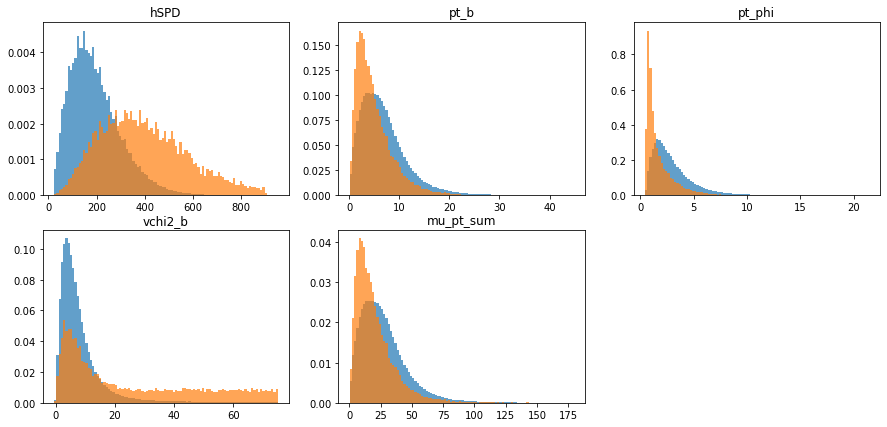

In [6]:
draw_distributions(original, target, original_weights)

### train part of original distribution

KS over  hSPD  =  0.5199346467661587


KS over  pt_b  =  0.21713799999870376


KS over  pt_phi  =  0.4005587363185321


KS over  vchi2_b  =  0.40429131342681207


KS over  mu_pt_sum  =  0.21713799999870376


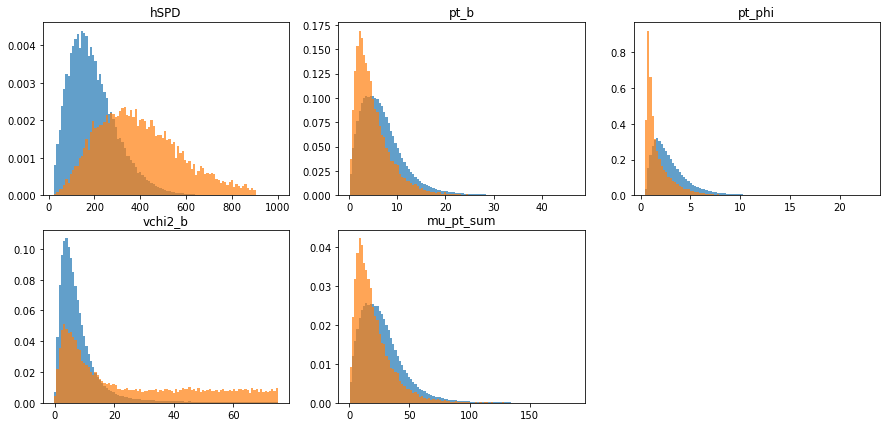

In [7]:
draw_distributions(original_train, target_train, original_weights_train)

### test part for target distribution

KS over  hSPD  =  0.5220128076851445


KS over  pt_b  =  0.2175341372875016


KS over  pt_phi  =  0.4078936485729074


KS over  vchi2_b  =  0.41039877597546376


KS over  mu_pt_sum  =  0.2175341372875016


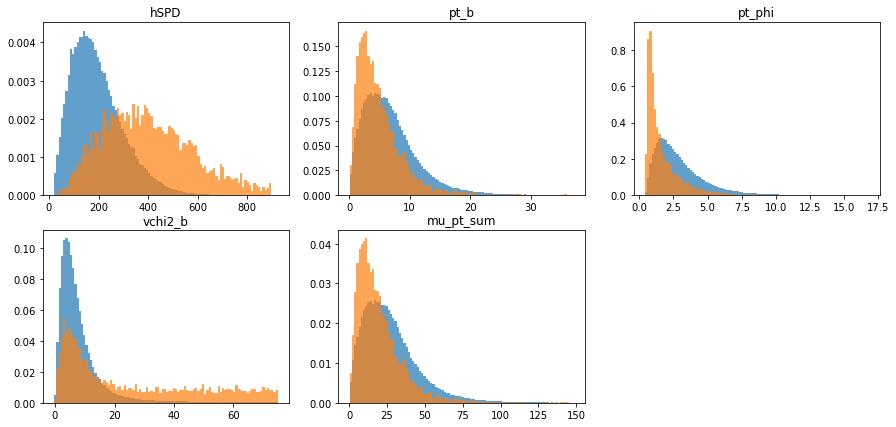

In [8]:
draw_distributions(original_test, target_test, original_weights_test)

### Bins-based reweighting in n dimensions

Typical way to reweight distributions is based on bins.


Usually histogram reweighting is used, in each bin the weight of original
distribution is multiplied by:

$m_{bin} = \frac{w_{target}}{w_{original}}$

where $w_{target}$ and $w_{original}$ are the total weight of events in each bin for target and original distributions.

1. Simple and fast!
2. Very few (typically, one or two) variables
3. Reweighting one variable may bring disagreement in others
4. Which variable to use in reweighting?

KS over  hSPD  =  0.4150895864422493


KS over  pt_b  =  0.11662819746873682


KS over  pt_phi  =  0.28319045122105635


KS over  vchi2_b  =  0.3502882115668292


KS over  mu_pt_sum  =  0.11662819746873682


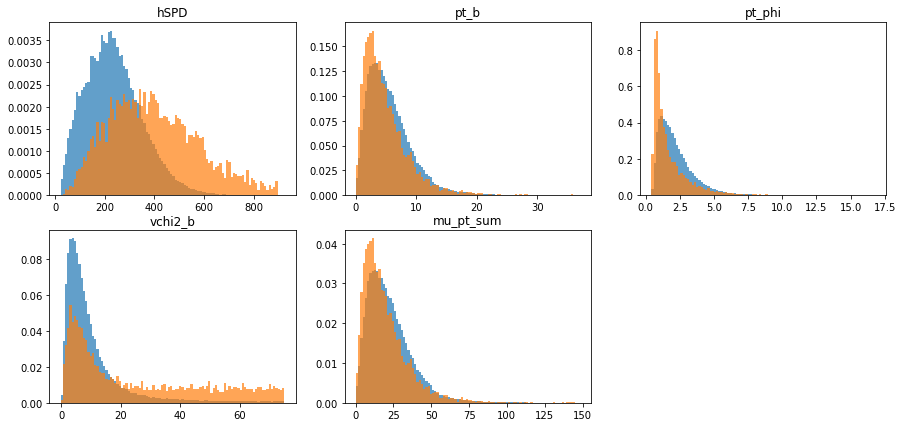

In [9]:
bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
bins_reweighter.fit(original_train, target_train)

bins_weights_test = bins_reweighter.predict_weights(original_test)
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original_test, target_test, bins_weights_test)

### Gradient Boosted Reweighter

This algorithm is inspired by gradient boosting and is able to fight curse of dimensionality.
It uses decision trees and special loss functiion (**ReweightLossFunction**).

A classifier is trained to discriminate between real data and MC. This means we are able to reweight in several variables rather than just one.
`GBReweighter` from `hep_ml` is able to handle many variables and requires less data (for the same performance).

**GBReweighter** supports negative weights (to reweight MC to splotted real data).

KS over  hSPD  =  0.04789300130883334


KS over  pt_b  =  0.047920619015482724


KS over  pt_phi  =  0.0484965016339865


KS over  vchi2_b  =  0.013611903963800354


KS over  mu_pt_sum  =  0.047920619015482724


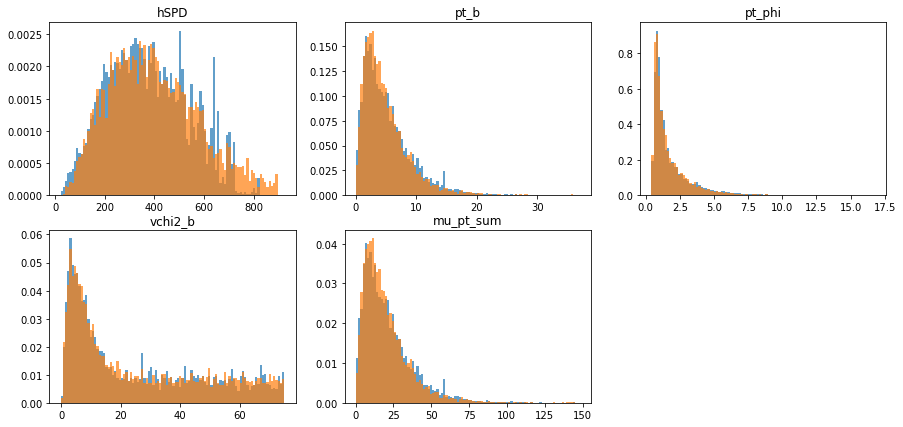

In [10]:
reweighter = reweight.GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=1000, 
                                   gb_args={'subsample': 0.4})
reweighter.fit(original_train, target_train)

gb_weights_test = reweighter.predict_weights(original_test)
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original_test, target_test, gb_weights_test)

## Comparing some simple expressions:
The most interesting is checking some other variables in multidimensional distributions (those are expressed via original variables).
Here we can check the KS distance in multidimensional distributions. (The lower the value, the better agreement of distributions.)

In [11]:
def check_ks_of_expression(expression):
    col_original = original_test.eval(expression, engine='python')
    col_target = target_test.eval(expression, engine='python')
    w_target = numpy.ones(len(col_target), dtype='float')
    print('No reweight   KS:', ks_2samp_weighted(col_original, col_target, 
                                                 weights1=original_weights_test, weights2=w_target))
    print('Bins reweight KS:', ks_2samp_weighted(col_original, col_target, 
                                                 weights1=bins_weights_test, weights2=w_target))
    print('GB Reweight   KS:', ks_2samp_weighted(col_original, col_target,
                                                 weights1=gb_weights_test, weights2=w_target))

In [12]:
check_ks_of_expression('hSPD')

No reweight   KS: 0.5220128076851445
Bins reweight KS: 0.4150895864422493
GB Reweight   KS: 0.04789300130883334


In [13]:
check_ks_of_expression('hSPD * pt_phi')

No reweight   KS: 0.08472278716674933


Bins reweight KS: 0.10946306551541043
GB Reweight   KS: 0.02094557532783331


In [14]:
check_ks_of_expression('hSPD * pt_phi * vchi2_b')

No reweight   KS: 0.36959882671209365
Bins reweight KS: 0.3343801780750291
GB Reweight   KS: 0.020435052906607853


In [15]:
check_ks_of_expression('pt_b * pt_phi / hSPD ')

No reweight   KS: 0.4804309080394009
Bins reweight KS: 0.3775297213695529
GB Reweight   KS: 0.04876788235936058


In [16]:
check_ks_of_expression('hSPD * pt_b * vchi2_b / pt_phi')

No reweight   KS: 0.5061082637575225
Bins reweight KS: 0.4119223886515931
GB Reweight   KS: 0.026424362416813008


### GB-discrimination
Let's check how well a classifier is able to distinguish these distributions. 

For this puprose we split the data into train and test, then we train a classifier to distinguish between the real data and MC distributions.

We can use the ROC Area Under Curve as a measure of performance.
If ROC AUC = 0.5 on the test sample, the distibutions are identical, if ROC AUC = 1.0, they are ideally separable. So we want a ROC AUC as close to 0.5 as possible to know that we cannot separate the reweighted distributions.


In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

data = numpy.concatenate([original_test, target_test])
labels = numpy.array([0] * len(original_test) + [1] * len(target_test))

weights = {}
weights['original'] = original_weights_test
weights['bins'] = bins_weights_test
weights['gb_weights'] = gb_weights_test


for name, new_weights in weights.items():
    W = numpy.concatenate([new_weights / new_weights.sum() * len(target_test), [1] * len(target_test)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)
    
    print(name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts))

original 0.9388062959928501


bins 0.9094854555764568


gb_weights 0.5672755194236474


### Folding reweighter

`FoldingReweighter` uses k folding in order to obtain unbiased weights for the whole distribution.

KFold prediction using folds column


KS over  hSPD  =  0.04441259456134028


KS over  pt_b  =  0.03192873182943756


KS over  pt_phi  =  0.02820234463330315


KS over  vchi2_b  =  0.021280218250367522


KS over  mu_pt_sum  =  0.03192873182943756


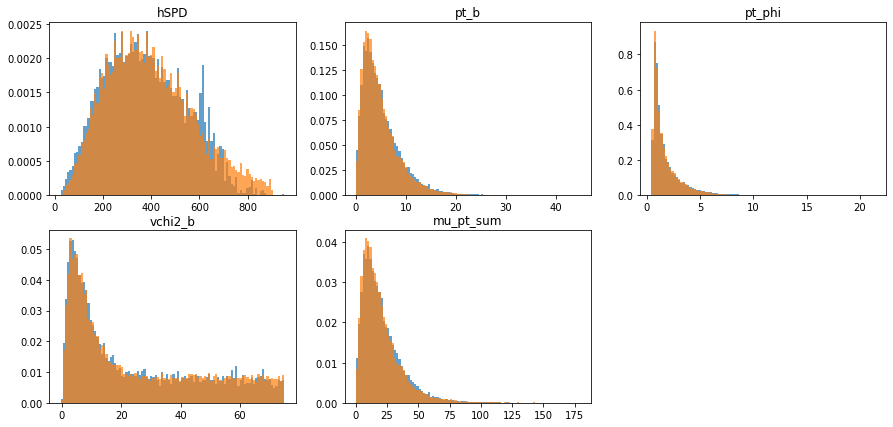

In [18]:
# define base reweighter
reweighter_base = reweight.GBReweighter(n_estimators=50, 
                                        learning_rate=0.1, max_depth=3, min_samples_leaf=1000, 
                                        gb_args={'subsample': 0.4})
reweighter = reweight.FoldingReweighter(reweighter_base, n_folds=2)
# it is not needed divide data into train/test parts; rewighter can be train on the whole samples
reweighter.fit(original, target)

# predict method provides unbiased weights prediction for the whole sample
# folding reweighter contains two reweighters, each is trained on one half of samples
# during predictions each reweighter predicts another half of samples not used in training
folding_weights = reweighter.predict_weights(original)

draw_distributions(original, target, folding_weights)

### GB discrimination for reweighting rule

In [19]:
data = numpy.concatenate([original, target])
labels = numpy.array([0] * len(original) + [1] * len(target))

weights = {}
weights['original'] = original_weights
weights['2-folding'] = folding_weights


for name, new_weights in weights.items():
    W = numpy.concatenate([new_weights / new_weights.sum() * len(target), [1] * len(target)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=30).fit(Xtr, Ytr, sample_weight=Wtr)
    
    print(name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts))

original 0.9369186800084836


2-folding 0.5776090834406724
